In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.lines import Line2D
from matplotlib.patches import ConnectionPatch
from cmcrameri import cm

import qnmfits
import utils

plt.rcParams.update(utils.rcparams)

In [2]:
sim_info = utils.load_cce_data(1)
sim = sim_info['sim']
chif = sim.chif_mag
Mf = sim.Mf

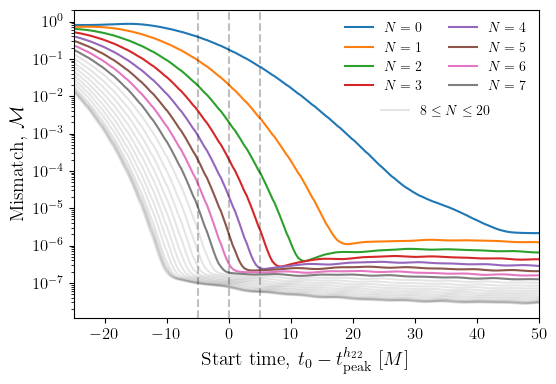

In [3]:
# The mode combinations to try
mode_list = [[(2,2,n,1) for n in range(N)] for N in range(1,22)]

# The start times to use
t0_array = np.linspace(-25, 50, 200)
T = 90

# Create figure
fig, ax = plt.subplots(figsize=(6,(6/1.5)))

for modes in mode_list:
    
    n = modes[-1][-2]
    
    # Create mismatch list
    mm_list = qnmfits.mismatch_t0_array(
        sim.times,
        sim.h,
        modes,
        sim.Mf,
        sim.chif_mag,
        t0_array, 
        T_array=T,
        spherical_modes=[(2,2)]
        )
    
    if n < 8:
        c = f'C{n}'
        label = f'$N = {n}$'
        alpha=1
        ls='-'
    else:
        c = 'k'
        label=None
        alpha=0.1
        ls='-'
    
    # Add to figure
    ax.semilogy(t0_array, mm_list, c=c, label=label, alpha=alpha, ls=ls)
    
ax.axvline(5, c='k', linestyle='--', alpha=0.25)
ax.axvline(0, c='k', linestyle='--', alpha=0.25)
ax.axvline(-5, c='k', linestyle='--', alpha=0.25)
    
# Plot limits and labels
ax.set_xlim(t0_array[0], t0_array[-1])
ax.set_xlabel('Start time, $t_0 - t_\mathrm{peak}^{h_{22}}\ [M]$')
ax.set_ylabel('Mismatch, $\mathcal{M}$')

l1 = ax.legend(frameon=False, loc='upper right', fontsize=10, ncol=2)
ax.add_artist(l1)

ax.legend(
    [Line2D([0], [0], c='k', alpha=0.1)],
    ['$8 \leq N \leq 20$'],
    frameon=False, 
    fontsize=10,
    loc='upper right',
    bbox_to_anchor=(0.92225,0.73)
    );

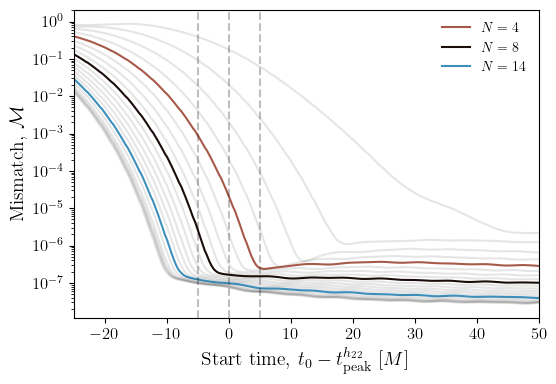

In [4]:
# The mode combinations to try
mode_list = [[(2,2,n,1) for n in range(N)] for N in range(1,22)]

# The start times to use
t0_array = np.linspace(-25, 50, 200)
T = 90

# Create figure
fig, ax = plt.subplots(figsize=(6,(6/1.5)))

for modes in mode_list:
    
    n = modes[-1][-2]
    
    # Create mismatch list
    mm_list = qnmfits.mismatch_t0_array(
        sim.times,
        sim.h,
        modes,
        sim.Mf,
        sim.chif_mag,
        t0_array, 
        T_array=T,
        spherical_modes=[(2,2)]
        )
    
    if n == 4:
        c = cm.berlin(0.5+((2-1)/3))
        label = f'$N = {n}$'
        alpha=1
        ls='-'
    elif n == 8:
        c = cm.berlin(0.5+((1-1)/3))
        label = f'$N = {n}$'
        alpha=1
        ls='-'
    elif n == 14:
        c = cm.berlin(0.5+((0-1)/3))
        label = f'$N = {n}$'
        alpha=1
        ls='-'
    else:
        c = 'k'
        label=None
        alpha=0.1
        ls='-'
    
    # Add to figure
    ax.semilogy(t0_array, mm_list, c=c, label=label, alpha=alpha, ls=ls)
    
ax.axvline(5, c='k', linestyle='--', alpha=0.25)
ax.axvline(0, c='k', linestyle='--', alpha=0.25)
ax.axvline(-5, c='k', linestyle='--', alpha=0.25)
    
# Plot limits and labels
ax.set_xlim(t0_array[0], t0_array[-1])
ax.set_xlabel('Start time, $t_0 - t_\mathrm{peak}^{h_{22}}\ [M]$')
ax.set_ylabel('Mismatch, $\mathcal{M}$')

ax.legend(frameon=False, loc='upper right', fontsize=10, ncol=1);

In [5]:
# Calculate epsilon for an increasing number of overtones, for three different 
# start time choices

N_list = list(range(21))
fit_times = [-10, 0, 10]
epsilon_dict = {fit_time: [] for fit_time in fit_times}

for fit_time in fit_times:

    for N in N_list:

        modes = [(2,2,n,1) for n in range(N+1)]

        epsilon, Mf_bestfit, chif_bestfit = qnmfits.calculate_epsilon(
                sim.times, 
                sim.h, 
                modes=modes, 
                Mf=sim.Mf, 
                chif=sim.chif_mag, 
                t0=fit_time, 
                T=T, 
                spherical_modes=[(2,2)]
                )

        epsilon_dict[fit_time].append(epsilon)

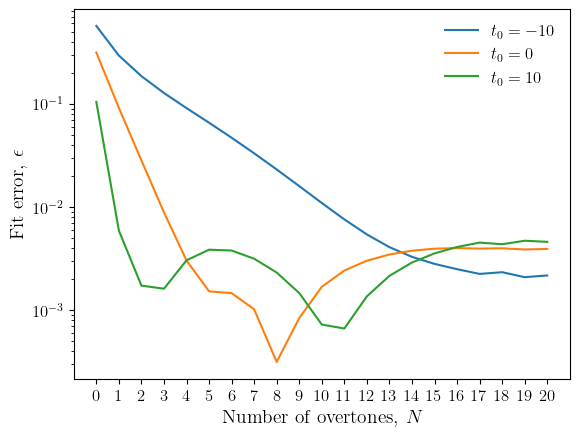

In [6]:
fig, ax = plt.subplots()

for fit_time in fit_times:
    ax.plot(N_list, epsilon_dict[fit_time], label=f'$t_0 = {fit_time}$')

ax.set_xlabel('Number of overtones, $N$')
ax.set_ylabel('Fit error, $\epsilon$')

ax.set_yscale('log')

ax.legend(frameon=False)

ax.set_xticks(N_list);

In [7]:
# For each start time, there is a number of overtones for which epsilon is a 
# minimum. Find the QNM amplitudes for each of these minimum-epsilon fits.

amp_dict = {}
phase_dict = {}
best_N_list = []

N_lim = 18
for fit_time, epsilon_list in epsilon_dict.items():

    best_N = np.argmin(epsilon_list[:N_lim])
    best_N_list.append(best_N)
    N_lim = best_N
    
    best_fit = qnmfits.ringdown_fit(
        sim.times, 
        sim.h[2,2], 
        [(2,2,n,1) for n in range(best_N+1)],
        sim.Mf,
        sim.chif_mag,
        fit_time,
        T=T
        )
    
    C = best_fit['C']
    
    rescaled_C = []
    for n in range(best_N+1):
        tau = -1/np.imag(qnmfits.qnm.omega(2, 2, n, 1, chif=sim.chif_mag, Mf=sim.Mf))
        omega = qnmfits.qnm.omega(2, 2, n, 1, chif=sim.chif_mag, Mf=sim.Mf)
        rescaled_C.append(C[n]*np.exp(1j*fit_time*omega))
        # rescaled_C.append(abs(C)[n]*np.exp(fit_time/tau))
        
    amp_dict[fit_time] = [np.abs(C), np.abs(rescaled_C)]
    phase_dict[fit_time] = [np.angle(C), np.angle(rescaled_C)]

In [8]:
phase_dict[0][0]

array([-0.19769398, -2.36077144,  1.12736895, -2.15171882,  0.50938589,
        3.07328109, -0.5449978 ,  2.29426571, -1.03155408])

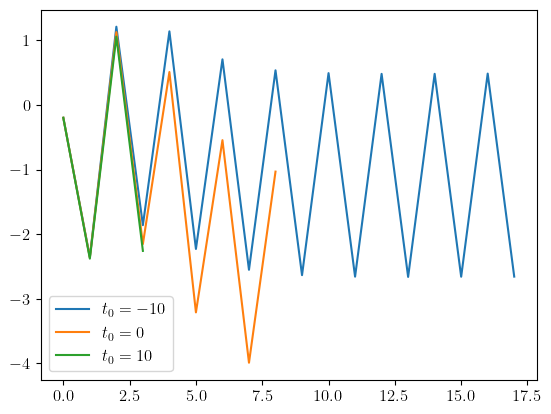

In [9]:
fig, ax = plt.subplots()

for key in [-10, 0, 10]:
    phases = phase_dict[key][1]
    phases[phases > 2] -= 2*np.pi
    ax.plot(np.arange(len(phase_dict[key][0])), phases, label=f'$t_0 = {key}$')
ax.legend();

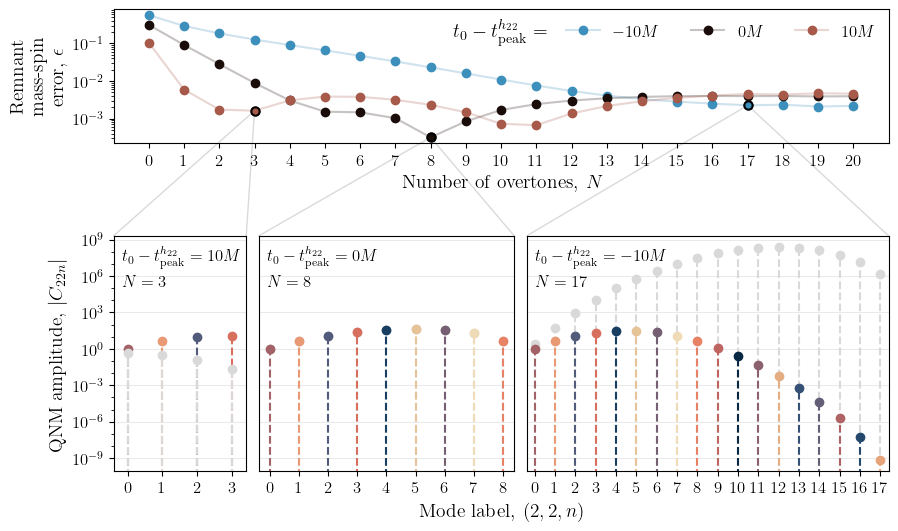

In [10]:
fig = plt.figure(figsize=(10, 6))

width_ratios = np.array(best_N_list[::-1])/(np.array(best_N_list[::-1])+10)
width_ratios /= width_ratios[0]

main_grid = fig.add_gridspec(
    2, 
    3, 
    height_ratios=[1,1.75], 
    width_ratios=width_ratios, 
    hspace=0.5, 
    wspace=0.05
)
ax1 = fig.add_subplot(main_grid[0, :])
ax2, ax3, ax4 = [fig.add_subplot(main_grid[1, i]) for i in range(3)]

ax1.set_yscale('log')
ax2.set_yscale('log')
ax3.set_yscale('log')
ax4.set_yscale('log')

ax3.set_yticks([])
ax4.set_yticks([])

ax1.set_xlabel('Number of overtones, $N$')
ax1.set_ylabel('Remnant \nmass-spin \nerror, $\epsilon$')

ax2.set_ylabel('QNM amplitude, $|C_{22 n}|$')

ax3.set_xlabel('Mode label, $(2,2,n)$')
ax3.xaxis.set_label_coords(0.95, -0.13)

# --------------------------------------

for i, (fit_time, epsilon_list) in enumerate(epsilon_dict.items()):
    
    c = cm.berlin(0.5+((i-1)/3))
    line_c = list(c)[:3] + [0.25]

    ax1.plot(
        N_list, 
        epsilon_list, 
        c=line_c, 
        marker='o', 
        label=f'${fit_time}M$', 
        markeredgecolor=c, 
        markerfacecolor=c
        )
    
ax1.set_xticks(N_list)

ax1.text(
    0.56, 
    0.93, 
    '$t_0 - t_\mathrm{peak}^{h_{22}} = $', 
    horizontalalignment='right',
    verticalalignment='top', 
    transform=ax1.transAxes
    )

ax1.legend(
    ncol=3, 
    frameon=False,
    loc='upper right'
)

# -------------

for i in range(len(amp_dict)):
    
    ax = [ax4, ax3, ax2][i]
    fit_time = fit_times[i]

    amps = amp_dict[fit_time][0]
    rescaled_amps = amp_dict[fit_time][1]

    x = np.arange(len(amps))
    x_shift = 0

    for j in range(len(x)):

        ls = '--'

        if i == 2:
            zorder=5
        else:
            zorder=0.9
        ax.plot(
            [x[j]-x_shift,x[j]-x_shift], [0,amps[j]], 
            color='#d9d9d9', 
            marker='o', 
            markevery=(1,2), 
            linestyle=ls,
            zorder=zorder
            )

        c = cm.lipariS(j+2) #  plt.cm.viridis(i/20)
        ls = '--'

        ax.plot(
            [x[j]+x_shift,x[j]+x_shift], [0,rescaled_amps[j]], 
            color=c, 
            marker='o', 
            markevery=(1,2), 
            linestyle=ls,
            zorder=1
            )

ax2.set_xticks([0,1,2,3])
ax3.set_xticks([0,1,2,3,4,5,6,7,8])
# ax4.set_xticks([0,2,4,6,8,10,12,14,16])
ax4.set_xticks(np.arange(0, 18))

# minor_yticks = [j*10**i for i in range(-3,5) for j in range(1,10)] 
# ax2.set_yticks(minor_yticks, minor=True)
minor_yticks = [10**i for i in range(-8,9)] 
ax2.set_yticks(minor_yticks, labels=17*[''], minor=True)
ax2.set_yticks(
    [1e-9, 1e-6, 1e-3, 1e0, 1e3, 1e6, 1e9],
    labels=['$10^{-9}$', '$10^{-6}$', '$10^{-3}$', '$10^0$', '$10^3$', '$10^6$', '$10^9$']
    )

for ax, best_N in zip([ax4, ax3, ax2], best_N_list):
    ax.set_xlim(0-0.4, best_N+0.4)
    
ylim = ax4.get_ylim()
new_ylim = (ylim[0], 2e9)

ax2.set_ylim(new_ylim)
ax3.set_ylim(new_ylim)
ax4.set_ylim(new_ylim)

grid_locs = [1e-9, 1e-6, 1e-3, 1e0, 1e3, 1e6, 1e9]
for loc in grid_locs:
    ax2.axhline(loc, c='k', alpha=0.1, zorder=-10, lw=0.6)
    ax3.axhline(loc, c='k', alpha=0.1, zorder=-10, lw=0.6)
    ax4.axhline(loc, c='k', alpha=0.1, zorder=-10, lw=0.6)
    
for i, (fit_time, epsilon_list) in enumerate(epsilon_dict.items()):
    
    ax = [ax4, ax3, ax2][i]
    
    min_loc = best_N_list[i]
    min_epsilon = epsilon_list[min_loc]
    min_N = N_list[min_loc]
    
    fig.add_artist(
        ConnectionPatch(
            xyA=(min_N,min_epsilon), 
            coordsA=ax1.transData, 
            xyB=(0,1), 
            coordsB=ax.transAxes,
            color='k',
            alpha=0.15,
            zorder=0.
            )
        )
    
    fig.add_artist(
        ConnectionPatch(
            xyA=(min_N,min_epsilon), 
            coordsA=ax1.transData, 
            xyB=(1,1), 
            coordsB=ax.transAxes,
            color='k',
            alpha=0.15,
            zorder=0.
            )
        )
    
    c = cm.berlin(0.5+((i-1)/3)) # f'C{i}'
    ax1.plot(min_N, min_epsilon, marker='o', c=c, markeredgecolor='k', markeredgewidth=1.5)
    
    ax.text(
        0.06/width_ratios[len(width_ratios)-1-i], 
        0.91, 
        f' $t_0 - t_\mathrm{{peak}}^{{h_{{22}}}} = {fit_time}M$', 
        horizontalalignment='left',
        verticalalignment='center', 
        transform=ax.transAxes,
        fontsize=12
        )
    
    ax.text(
        0.06/width_ratios[len(width_ratios)-1-i], 
        0.805, 
        f'$N={min_N}$', 
        horizontalalignment='left',
        verticalalignment='center', 
        transform=ax.transAxes,
        fontsize=12
        )
    
ax1.patch.set_alpha(0.)

fig.savefig('figures/even_more_overtones.pdf', bbox_inches='tight')

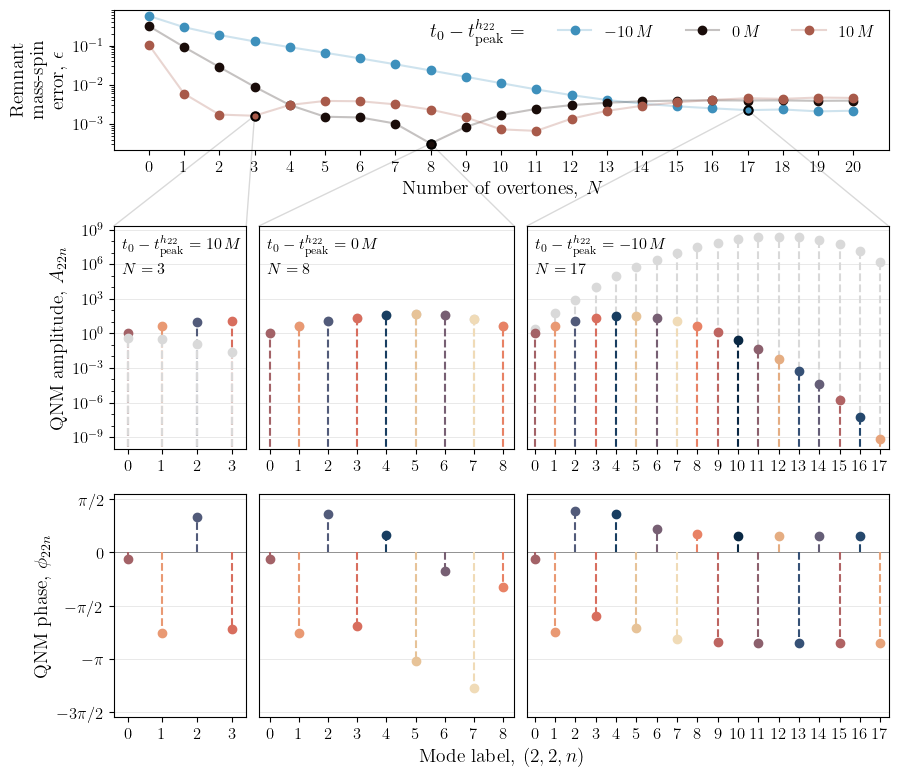

In [11]:
fig = plt.figure(figsize=(10, 8))

width_ratios = np.array(best_N_list[::-1])/(np.array(best_N_list[::-1])+10)
width_ratios /= width_ratios[0]

subfigs = fig.subfigures(2, 1, height_ratios=[1, 3.5], hspace=-0.05)
ax1 = subfigs[0].subplots(1, 1)

axs = subfigs[1].subplots(2, 3, width_ratios=width_ratios)
amp_axs = axs[0]
phase_axs = axs[1]
subfigs[1].subplots_adjust(wspace=0.05)

ax1.set_yscale('log')
for ax in amp_axs:
    ax.set_yscale('log')

for amp_ax, phase_ax in zip(amp_axs[1:], phase_axs[1:]):
    amp_ax.set_yticks([])
    phase_ax.set_yticks([])

ax1.set_xlabel('Number of overtones, $N$')
ax1.set_ylabel('Remnant \nmass-spin \nerror, $\epsilon$')

amp_axs[0].set_ylabel('QNM amplitude, $A_{22 n}$')
phase_axs[0].set_ylabel('QNM phase, $\phi_{22 n}$')

phase_axs[1].set_xlabel('Mode label, $(2,2,n)$')
phase_axs[1].xaxis.set_label_coords(0.95, -0.135)

# --------------------------------------

for i, (fit_time, epsilon_list) in enumerate(epsilon_dict.items()):
    
    c = cm.berlin(0.5+((i-1)/3))
    line_c = list(c)[:3] + [0.25]

    ax1.plot(
        N_list, 
        epsilon_list, 
        c=line_c, 
        marker='o', 
        label=f'${fit_time}\,M$', 
        markeredgecolor=c, 
        markerfacecolor=c
        )
    
ax1.set_xticks(N_list)

ax1.text(
    0.53, 
    0.93, 
    '$t_0 - t_\mathrm{peak}^{h_{22}} = $', 
    horizontalalignment='right',
    verticalalignment='top', 
    transform=ax1.transAxes
    )

ax1.legend(
    ncol=3, 
    frameon=False,
    loc='upper right'
)

# -------------

for i in range(len(amp_dict)):
    
    ax_amp = amp_axs[::-1][i]
    ax_phase = phase_axs[::-1][i]
    fit_time = fit_times[i]

    amps = amp_dict[fit_time][0]
    rescaled_amps = amp_dict[fit_time][1]
    rescaled_phases = phase_dict[fit_time][1]

    x = np.arange(len(amps))

    for j in range(len(x)):

        ls = '--'

        if i == 2:
            zorder=5
        else:
            zorder=0.9
        ax_amp.plot(
            [x[j],x[j]], [0,amps[j]], 
            color='#d9d9d9', 
            marker='o', 
            markevery=(1,2), 
            linestyle=ls,
            zorder=zorder
            )

        c = cm.lipariS(j+2) #  plt.cm.viridis(i/20)
        ls = '--'

        ax_amp.plot(
            [x[j],x[j]], [0,rescaled_amps[j]], 
            color=c, 
            marker='o', 
            markevery=(1,2), 
            linestyle=ls,
            zorder=1
            )
        
        ax_phase.plot(
            [x[j],x[j]], 
            [0,rescaled_phases[j]], 
            color=c, 
            marker='o', 
            markevery=(1,2), 
            linestyle=ls,
            zorder=1
            )

for N, amp_ax, phase_ax in zip(best_N_list[::-1], amp_axs, phase_axs):
    amp_ax.set_xticks(np.arange(0, N+1))
    phase_ax.set_xticks(np.arange(0, N+1))

minor_yticks = [10**i for i in range(-8,9)]
amp_axs[0].set_yticks(minor_yticks, labels=17*[''], minor=True)
amp_axs[0].set_yticks(
    [1e-9, 1e-6, 1e-3, 1e0, 1e3, 1e6, 1e9],
    labels=['$10^{-9}$', '$10^{-6}$', '$10^{-3}$', '$10^0$', '$10^3$', '$10^6$', '$10^9$']
    )

for ax, best_N in zip(amp_axs[::-1], best_N_list):
    ax.set_xlim(0-0.4, best_N+0.4)

for ax, best_N in zip(phase_axs[::-1], best_N_list):
    ax.set_xlim(0-0.4, best_N+0.4)
    
ylim = amp_axs[-1].get_ylim()
new_ylim = (ylim[0], 2e9)
for ax in amp_axs:
    ax.set_ylim(new_ylim)

grid_locs = [1e-9, 1e-6, 1e-3, 1e0, 1e3, 1e6, 1e9]
for loc in grid_locs:
    for ax in amp_axs:
        ax.axhline(loc, c='k', alpha=0.1, zorder=-10, lw=0.6)

new_ylim = (-1.5*np.pi-0.15, np.pi/2+0.15)
for ax in phase_axs:
    ax.set_ylim(new_ylim)
phase_axs[0].set_yticks(
    [-1.5*np.pi, -np.pi, -np.pi/2, 0, np.pi/2],
    labels=[r'$-3\pi/2$', r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$']
)

grid_locs = [-1.5*np.pi, -np.pi, -np.pi/2, 0, np.pi/2]
for loc in grid_locs:
    for ax in phase_axs:
        if loc == 0:
            alpha = 0.5
        else:
            alpha = 0.1
        ax.axhline(loc, c='k', alpha=alpha, zorder=-10, lw=0.6)
    
for i, (fit_time, epsilon_list) in enumerate(epsilon_dict.items()):
    
    ax = amp_axs[::-1][i]
    
    min_loc = best_N_list[i]
    min_epsilon = epsilon_list[min_loc]
    min_N = N_list[min_loc]
    
    fig.add_artist(
        ConnectionPatch(
            xyA=(min_N,min_epsilon), 
            coordsA=ax1.transData, 
            xyB=(0,1), 
            coordsB=ax.transAxes,
            color='k',
            alpha=0.15,
            zorder=0.
            )
        )
    
    fig.add_artist(
        ConnectionPatch(
            xyA=(min_N,min_epsilon), 
            coordsA=ax1.transData, 
            xyB=(1,1), 
            coordsB=ax.transAxes,
            color='k',
            alpha=0.15,
            zorder=0.
            )
        )
    
    c = cm.berlin(0.5+((i-1)/3)) # f'C{i}'
    ax1.plot(min_N, min_epsilon, marker='o', c=c, markeredgecolor='k', markeredgewidth=1.5)
    
    ax.text(
        0.06/width_ratios[len(width_ratios)-1-i], 
        0.91, 
        f' $t_0 - t_\mathrm{{peak}}^{{h_{{22}}}} = {fit_time}\,M$', 
        horizontalalignment='left',
        verticalalignment='center', 
        transform=ax.transAxes,
        fontsize=11.5
        )
    
    ax.text(
        0.06/width_ratios[len(width_ratios)-1-i], 
        0.805, 
        f'$N={min_N}$', 
        horizontalalignment='left',
        verticalalignment='center', 
        transform=ax.transAxes,
        fontsize=11.5
        )
    
ax1.patch.set_alpha(0.)

fig.savefig('figures/even_more_overtones.pdf', bbox_inches='tight')